In [1]:
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from scipy.sparse import csr_matrix

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix, eye
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh

/Users/jingtaoxu/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
def create_adjacency_matrix(tree):
    """
    Create an adjacency matrix in CSR format for the given decision tree.
    """
    # Number of nodes in the tree
    n_nodes = tree.node_count

    # Initialize the lists to create CSR matrix
    data = []
    row_ind = []
    col_ind = []

    # Iterate over each node in the tree
    for node in range(n_nodes):
        left_child = tree.children_left[node]
        right_child = tree.children_right[node]

        # Check if the left child exists
        if left_child != -1:
            # Add an edge from the current node to the left child
            row_ind.append(node)
            col_ind.append(left_child)
            data.append(1)  # weight of the edge

        # Check if the right child exists
        if right_child != -1:
            # Add an edge from the current node to the right child
            row_ind.append(node)
            col_ind.append(right_child)
            data.append(1)  # weight of the edge

    # Create the CSR matrix
    adjacency_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(n_nodes, n_nodes))
    return adjacency_matrix

In [4]:
def laplacian_eigenmaps(
    adjacency_matrix: csr_matrix,
    embed_dim: int,
    norm_laplacian: bool = False,
) -> np.ndarray:
  L, D = laplacian(adjacency_matrix.astype('float32'), normed=norm_laplacian, symmetrized=True, return_diag=True)
  L *= -1
  L += eye(*L.shape)
  eigenvals, eigenvecs = eigsh(L, k=embed_dim + 1, sigma=1.0, which='LM')

  # drop the zero eigenvalue and constant eigenvector
  eigenvals = eigenvals[:-1]
  eigenvecs = eigenvecs[:, :-1]

  eigenvals = 1 - eigenvals
  eigenvecs = eigenvecs / D[:, None]

  return eigenvals, eigenvecs

In [5]:
def plot_graph_with_edges(eigvec1, eigvec2, adjacency_matrix,title = 'Graph with Edges'):
    # Use first two eigenvectors for 2D plot coordinates
    x = eigvec1
    y = eigvec2

    # Plot nodes
    plt.scatter(x, y)

    # Draw edges
    rows, cols = adjacency_matrix.nonzero()
    for i in range(len(rows)):
        plt.plot([x[rows[i]], x[cols[i]]], [y[rows[i]], y[cols[i]]], 'k-', alpha=0.5)
    
    plt.xlabel('Eigenvector 1')
    plt.ylabel('Eigenvector 2')
    plt.title(title)
#     plt.savefig(title+'.png')
    plt.show()

In [6]:
from scipy.sparse import csr_matrix, hstack, vstack, diags
from scipy.sparse.csgraph import laplacian

def hyperbolic_laplacian(adjacency_matrix: csr_matrix, alpha: [float]) -> csr_matrix:
    """
    Create a hyperbolic Laplacian matrix for a given adjacency matrix and alpha vector.

    :param adjacency_matrix: Sparse adjacency matrix of the graph.
    :param alpha: Vector of alpha values.
    :return: Sparse hyperbolic Laplacian matrix.
    """
    # Calculate the classic Laplacian matrix
    classic_laplacian = laplacian(adjacency_matrix, normed=False, symmetrized=True)

    # Modify the diagonal of the classic Laplacian by subtracting alpha
    modified_laplacian = classic_laplacian - diags(alpha, offsets=0)

    # Create the top row [-1, alpha^T] and bottom rows [alpha, modified_laplacian]
    top_row = hstack((csr_matrix([[-1]]), csr_matrix([alpha])))
    bottom_rows = hstack((csr_matrix(alpha).reshape(-1, 1), modified_laplacian))

    # Stack top row and bottom rows vertically
    hyperbolic_laplacian_matrix = vstack((top_row, bottom_rows))

    return hyperbolic_laplacian_matrix

In [7]:
def hyperbolic_laplacian_eigenmaps(adjacency_matrix: csr_matrix, alpha: np.ndarray, embed_dim: int) -> np.ndarray:
    """
    Compute the eigenvalues and eigenvectors of the hyperbolic Laplacian matrix.

    :param adjacency_matrix: Sparse adjacency matrix of the graph.
    :param alpha: 1D numpy array of alpha values for the hyperbolic Laplacian.
    :param embed_dim: Number of dimensions for embedding (number of eigenvalues/vectors to compute).
    :return: Tuple of eigenvalues and eigenvectors.
    """
    # Compute the hyperbolic Laplacian matrix
    h_laplacian = hyperbolic_laplacian(adjacency_matrix, alpha)

    

    # Calculate the eigenvalues and eigenvectors
    eigenvals, eigenvecs = eigsh(h_laplacian, k=embed_dim, which='SM')

    return eigenvals, eigenvecs

##### The hypothesis that projecting binary graphs into a suitable two-dimensional subspace in hyperbolic space results in minimal or no edge crossings has significant theoretical implications:

Geometric Representation of Graphs: This hypothesis explores the geometric representation of binary graphs in hyperbolic space. Due to its unique geometric properties, such as negative curvature, hyperbolic space is apt for representing graphs with high clustering and hierarchical structures. This representation can reveal intrinsic structures and properties of the graph.

Connection Between Topology and Geometry: By projecting into hyperbolic space and analyzing the intersection of edges, a deeper understanding can be gained about the relationship between the graph's topological structure and its geometric representation.

Geometric Optimization: Proving this hypothesis could provide insights into how to effectively represent complex networks in low-dimensional spaces, which is crucial for understanding and optimizing the geometric structure of graphs.

#### Not taking 2 eigenvectors and just plot them, but do the following: to take 3 eigenvectors and create projection on 2d plane in the following way: 
vertex i —> (x_i/x_0-y_i/y_0; x_i/x_0-z_i/z_0), so 2 coordinates of each vertex can be calculated using 3 components corresponding to 3 different eigenvectors. Note that zero eigenvector correspond to extension of the standard laplacian.

### For different trees - RandomForest, GradientBoosting and ExtraTrees

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

In [11]:
%%time
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=42)
rf_clf.fit(X_train, y_train)
# Train a Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=42)
gb_clf.fit(X_train, y_train)
# Train an Extra Trees Classifier
et_clf = ExtraTreesClassifier(n_estimators=10, max_depth=4, random_state=42)
et_clf.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


ExtraTreesClassifier(max_depth=4, n_estimators=10, random_state=42)

In [12]:
# Select a single tree from each ensemble for visualization
# For RandomForest and ExtraTrees
single_tree_rf = rf_clf.estimators_[0]
single_tree_et = et_clf.estimators_[0]
# For GradientBoosting
single_tree_gb = gb_clf.estimators_[0, 0]  # First tree of the first class

adj_matrix_rf = create_adjacency_matrix(single_tree_rf.tree_)
adj_matrix_gb = create_adjacency_matrix(single_tree_gb.tree_)
adj_matrix_et = create_adjacency_matrix(single_tree_et.tree_)

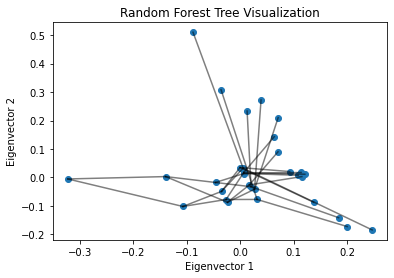

In [13]:
# For Random Forest tree
eigvals_rf, eigvecs_rf = laplacian_eigenmaps(adj_matrix_rf, embed_dim=10)
plot_graph_with_edges(eigvecs_rf[:, 0], eigvecs_rf[:, 1], adj_matrix_rf, title='Random Forest Tree Visualization')

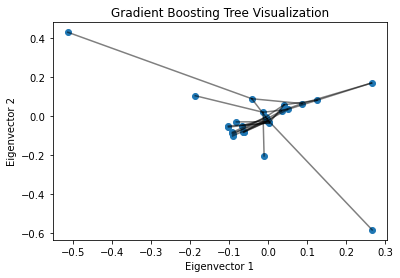

In [14]:
# For Gradient Boosting tree
eigvals_gb, eigvecs_gb = laplacian_eigenmaps(adj_matrix_gb, embed_dim=10)
plot_graph_with_edges(eigvecs_gb[:, 0], eigvecs_gb[:, 1], adj_matrix_gb, title='Gradient Boosting Tree Visualization')


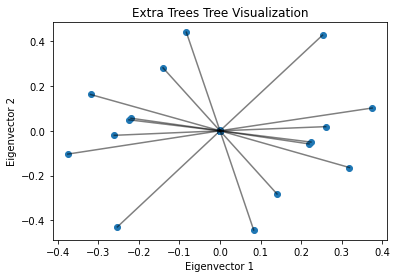

In [15]:
# For Extra Trees tree
eigvals_et, eigvecs_et = laplacian_eigenmaps(adj_matrix_et, embed_dim=10)
plot_graph_with_edges(eigvecs_et[:, 0], eigvecs_et[:, 1], adj_matrix_et, title='Extra Trees Tree Visualization')

[Text(0.5, 0.9, 'X[568] <= 0.5\ngini = 0.9\nsamples = 35417\nvalue = [5447, 6200, 5793, 5726, 5435, 5032, 5496, 5774, 5451\n5646]'),
 Text(0.25, 0.7, 'X[409] <= 0.5\ngini = 0.875\nsamples = 21708\nvalue = [703, 5176, 1244, 2928, 5190, 2184, 3236, 5562, 2530\n5473]'),
 Text(0.125, 0.5, 'X[295] <= 86.5\ngini = 0.745\nsamples = 6450\nvalue = [549, 4781, 517, 752, 279, 1006, 701, 562, 818, 249]'),
 Text(0.0625, 0.3, 'X[380] <= 5.5\ngini = 0.875\nsamples = 2410\nvalue = [421, 590, 212, 301, 187, 695, 540, 182, 529, 146]'),
 Text(0.03125, 0.1, 'gini = 0.835\nsamples = 1507\nvalue = [418, 421, 121, 88, 114, 638, 329, 90, 70, 70]'),
 Text(0.09375, 0.1, 'gini = 0.827\nsamples = 903\nvalue = [3, 169, 91, 213, 73, 57, 211, 92, 459, 76]'),
 Text(0.1875, 0.3, 'X[233] <= 1.0\ngini = 0.556\nsamples = 4040\nvalue = [128, 4191, 305, 451, 92, 311, 161, 380, 289, 103]'),
 Text(0.15625, 0.1, 'gini = 0.408\nsamples = 3416\nvalue = [93, 4174, 165, 226, 75, 247, 126, 156, 133, 61]'),
 Text(0.21875, 0.1, 'gin

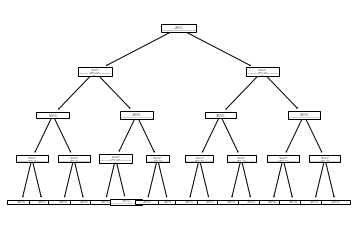

In [16]:
tree.plot_tree(single_tree_rf)

In [17]:
# Number of nodes in the tree
print(f"Number of nodes: {single_tree_rf.tree_.node_count}")

# Function to calculate the depth of the decision tree
def tree_depth(tree):
    """
    This function recursively finds the depth of a decision tree.
    """
    def _walk(node_id, current_depth):
        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]
        if left_child == right_child:  # leaf node
            return current_depth
        return max(_walk(left_child, current_depth + 1),
                   _walk(right_child, current_depth + 1))

    root_node_id = 0
    return _walk(root_node_id, 1)

# Calculate and print the depth of the tree
depth = tree_depth(single_tree_rf.tree_)
print(f"Depth of the tree: {depth}")

Number of nodes: 31
Depth of the tree: 5


In [18]:
def project_vertices(eigvecs):
    """
    Project vertices onto a 2D plane using components from three eigenvectors.

    The function uses a projection formula where each vertex `i` is mapped to a 2D point.
    The coordinates for each vertex are computed using components of three different eigenvectors
    (x, y, z) obtained from the hyperbolic Laplacian. The projection formula is as follows:
    
    x-coordinate: (x_i/x_0) - (y_i/y_0)
    y-coordinate: (x_i/x_0) - (z_i/z_0)
    
    where x_i, y_i, z_i are the components of the eigenvectors for vertex `i`,
    and x_0, y_0, z_0 are the components of the eigenvectors for the "zeroth" vertex,
    an additional component in the hyperbolic Laplacian.

    Parameters:
    eigvecs (numpy.ndarray): An array of eigenvectors obtained from the hyperbolic Laplacian.

    Returns:
    tuple: Two numpy arrays representing the projected x and y coordinates of the vertices.
    """
    x, y, z = eigvecs[:, 0], eigvecs[:, 1], eigvecs[:, 2]
    x0, y0, z0 = x[0], y[0], z[0]

    projected_x = x / x0 - y / y0
    projected_y = x / x0 - z / z0

    return projected_x, projected_y

In [19]:
def plot_projected_graph(projected_x, projected_y, adjacency_matrix, title='Projected Graph with 3 eigenvectors'):
    plt.scatter(projected_x, projected_y)
    rows, cols = adjacency_matrix.nonzero()
    for i in range(len(rows)):
        plt.plot([projected_x[rows[i]], projected_x[cols[i]]], [projected_y[rows[i]], projected_y[cols[i]]], 'k-', alpha=0.5)

    plt.xlabel('Projected X')
    plt.ylabel('Projected Y')
    plt.title(title)
    plt.show()


<AxesSubplot:>

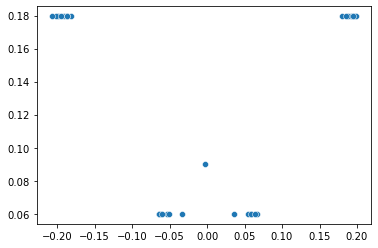

In [20]:
sns.scatterplot(x=eigvecs_rf[:, -2], y=eigvecs_rf[:, -1])

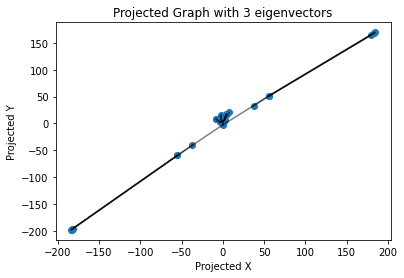

In [21]:
eigvals_rf, eigvecs_rf = laplacian_eigenmaps(adj_matrix_rf, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_rf)

plot_projected_graph(projected_x, projected_y, adj_matrix_rf)

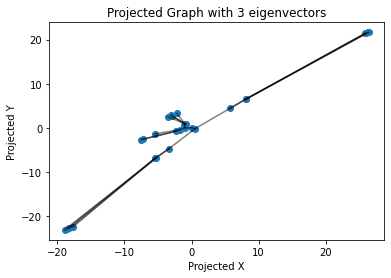

In [22]:
eigvals_gb, eigvecs_gb = laplacian_eigenmaps(adj_matrix_gb, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_gb)

plot_projected_graph(projected_x, projected_y, adj_matrix_gb)

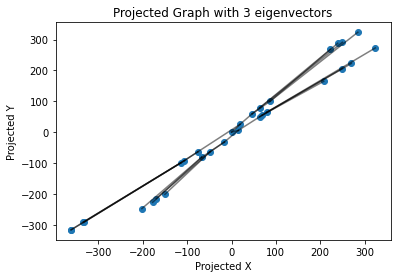

In [23]:
eigvals_et, eigvecs_et = laplacian_eigenmaps(adj_matrix_et, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_et)

plot_projected_graph(projected_x, projected_y, adj_matrix_et)